# Autour du Paradoxe de Simpson

## Import des librairies nécessaires

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tools.tools import add_constant
from statsmodels.discrete.discrete_model import Logit
from tqdm import tqdm

## Récupération et analyse des données

Nous pouvons charger la donnée stockée dans le dossier Gitlab ou en utilisant ce [lien](https://gitlab.inria.fr/learninglab/mooc-rr/mooc-rr-ressources/blob/master/module3/Practical_session/Subject6_smoking.csv)
Chaque ligne indique si la personne fume ou non, si elle est vivante ou décédée au moment de la seconde étude (1995), et son âge lors du premier sondage (1977).

In [2]:
data_path = "Subject6_smoking.csv"
# data_path = "https://gitlab.inria.fr/learninglab/mooc-rr/mooc-rr-ressources/blob/master/module3/Practical_session/Subject6_smoking.csv"

raw_data = pd.read_csv(data_path)
raw_data.head()

Smoker Status   Age
0    Yes  Alive  21.0
1    Yes  Alive  19.3
2     No   Dead  57.5
3     No  Alive  47.1
4    Yes  Alive  81.4

Regardons si certaines données sont manquantes : 

In [3]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [Smoker, Status, Age]
Index: []

Il ne manque pas de données ici.

## Représentation des décès en fonction de l'habitude de tabagisme

Nous pouvons regarder le nombre de personnes vivantes ou décédées en 1995 en fonction de si elles fument ou pas.

In [4]:
tableau_croise = pd.crosstab(raw_data["Smoker"], raw_data["Status"])
tableau_croise

Status  Alive  Dead
Smoker             
No        502   230
Yes       443   139

Nous pouvons également calculer le taux de mortalité par catégorie de fumeur

In [5]:
taux_mortalite = tableau_croise['Dead'] / tableau_croise.sum(axis=1)
taux_mortalite

Smoker
No     0.314208
Yes    0.238832
dtype: float64

Nous observons un taux de mortalité plus important pour les personnes non fumeuses (31% contre 24%), ce qui peut sembler surprenant à première vue.

Nous pouvons maintenant étudier si l'âge a un impact sur ce taux de mortalité

In [58]:
bins = [18, 34, 54, 64, float('inf')]  # Limites des catégories
labels = ['18-34 ans', '34-54 ans', '55-64 ans', 'plus de 65 ans']  # Noms des catégories
raw_data['Age_Category'] = pd.cut(raw_data['Age'], bins=bins, labels=labels, right=False)

# Création du tableau croisé en fonction de Smoker, Status et Age_Category
tableau_croise_age = pd.crosstab([raw_data['Smoker'], raw_data['Age_Category']], raw_data['Status'])

# Calcul du taux de mortalité par catégorie de fumeur et d'âge
taux_mortalite_age = tableau_croise_age['Dead'] / tableau_croise_age.sum(axis=1)

print("Tableau croisé :")
print(tableau_croise_age)
print("\nTaux de mortalité :")
print(taux_mortalite_age)

Tableau croisé :
Status                 Alive  Dead
Smoker Age_Category               
No     18-34 ans         213     6
       34-54 ans         180    19
       55-64 ans          80    39
       plus de 65 ans     29   166
Yes    18-34 ans         174     5
       34-54 ans         198    41
       55-64 ans          64    51
       plus de 65 ans      7    42

Taux de mortalité :
Smoker  Age_Category  
No      18-34 ans         0.027397
        34-54 ans         0.095477
        55-64 ans         0.327731
        plus de 65 ans    0.851282
Yes     18-34 ans         0.027933
        34-54 ans         0.171548
        55-64 ans         0.443478
        plus de 65 ans    0.857143
dtype: float64


En séparant par catégorie d'âge, le taux de mortalité des fumeurs est toujours supérieur à celui des non fumeurs. Cela peut s'expliquer par le fait que certaines variables ne sont pas indépendantes.

## Régression logistique

Créons dans un premier temps la variable Death

In [7]:
raw_data['Death'] = raw_data['Status'].apply(lambda x: 1 if x == 'Dead' else 0)

Séparons ensuite les données en fonction du groupe fumeurs ou non-fumeurs

In [8]:
data_fumeurs = raw_data[raw_data['Smoker'] == 'Yes']
data_non_fumeurs = raw_data[raw_data['Smoker'] == 'No']

Créons les modèles de régression logistique pour les deux catégories

In [59]:
def logistic_regression(data):
    X = add_constant(data['Age'])  # Ajoute une constante pour l'interception
    y = data['Death']
    model = Logit(y, X)
    result = model.fit()
    return result

result_fumeurs = logistic_regression(data_fumeurs)
result_non_fumeurs = logistic_regression(data_non_fumeurs)

print("Résumé de la régression pour les fumeurs :")
print(result_fumeurs.summary())

print("\nRésumé de la régression pour les non-fumeurs :")
print(result_non_fumeurs.summary())

Optimization terminated successfully.
         Current function value: 0.412727
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354560
         Iterations 7
Résumé de la régression pour les fumeurs :
                           Logit Regression Results                           
Dep. Variable:                  Death   No. Observations:                  582
Model:                          Logit   Df Residuals:                      580
Method:                           MLE   Df Model:                            1
Date:                Wed, 06 Nov 2024   Pseudo R-squ.:                  0.2492
Time:                        14:40:04   Log-Likelihood:                -240.21
converged:                       True   LL-Null:                       -319.94
                                        LLR p-value:                 1.477e-36
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

Nous allons maintenant faire des prédictions pour un éventail d'âges allant de 0 à 100 ans.

In [60]:
ages = np.linspace(raw_data['Age'].min(), raw_data['Age'].max(), 100)
X_ages = add_constant(ages)

Calculons les prédictions et les intervalles de confiance

In [61]:
# Fonction pour calculer les intervalles de confiance manuellement
def compute_confidence_interval(result, X, alpha=0.05):
    predictions = result.predict(X)
    # Calcul de l'erreur standard
    gradient = X @ result.cov_params() @ X.T
    std_error = np.sqrt(np.diag(gradient))
    
    # Calcul des intervalles de confiance (normal approx)
    z = 1.96  # Pour un intervalle de confiance de 95%
    lower_bound = predictions - z * std_error
    upper_bound = predictions + z * std_error
    return predictions, lower_bound, upper_bound

# Intervalles de confiance pour les fumeurs
pred_fumeurs, lower_fumeurs, upper_fumeurs = compute_confidence_interval(result_fumeurs, X_ages)

# Intervalles de confiance pour les non-fumeurs
pred_non_fumeurs, lower_non_fumeurs, upper_non_fumeurs = compute_confidence_interval(result_non_fumeurs, X_ages)

Enfin, affichons les résultats

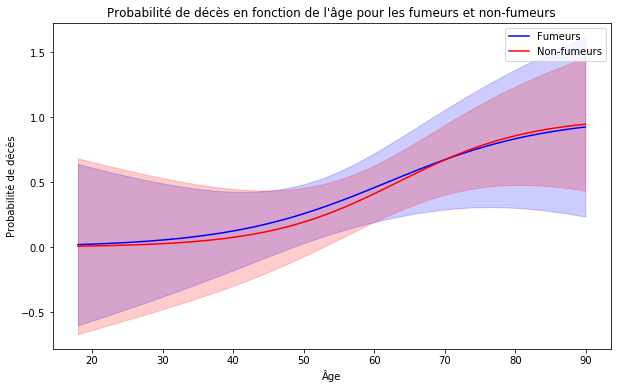

In [62]:
plt.figure(figsize=(10, 6))

# Courbe pour les fumeurs
plt.plot(ages, pred_fumeurs, color='blue', label='Fumeurs')
plt.fill_between(ages, lower_fumeurs, upper_fumeurs, color='blue', alpha=0.2)

# Courbe pour les non-fumeurs
plt.plot(ages, pred_non_fumeurs, color='red', label='Non-fumeurs')
plt.fill_between(ages, lower_non_fumeurs, upper_non_fumeurs, color='red', alpha=0.2)

plt.xlabel("Âge")
plt.ylabel("Probabilité de décès")
plt.title("Probabilité de décès en fonction de l'âge pour les fumeurs et non-fumeurs")
plt.legend()
plt.show()

La régression ne montre pas d'écart important entre les probabilités de décès des fumeurs et des non-fumeurs.